In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Mounted at /content/drive
/content/drive/My Drive/ann challenge


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()

## Auxiliary functions

In [5]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [6]:
def plot_history(history, log_scale: bool = False) -> None:
  mae = history['mae']
  val_mae = history['val_mae']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmin(val_loss)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')

  if log_scale:
      plt.semilogy(loss, label='Training MSE', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation MSE', color='#4D61E2')
  else:
      plt.plot(loss, label='Training MSE', color='#ff7f0e')
      plt.plot(val_loss, label='Validation MSE', color='#4D61E2')

  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')

  if log_scale:
     plt.semilogy(mae, label='Training MAE', color='#ff7f0e')
     plt.semilogy(val_mae, label='Validation MAE', color='#4D61E2')
  else:
    plt.plot(mae, label='Training MAE', color='#ff7f0e')
    plt.plot(val_mae, label='Validation MAE', color='#4D61E2')

  plt.plot(best_epoch, history['val_mae'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

## Load data

In [7]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)

In [8]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [9]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [10]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build the model

In [11]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = y_train.shape[1:]        # Output shape for the model
batch_size = 256                        # Batch size for training
epochs = 200                            # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 256
Input Shape: (200, 1)
Output Shape: (9, 1)


In [12]:
from tcn import TCN

In [13]:
def TemporalConvNet(num_filters, kernel_size, return_sequences, dilations, dropout_rate=0.0, nb_stacks=1):
    return TCN(
        nb_filters=num_filters,
        kernel_size=kernel_size,
        dilations=dilations,
        nb_stacks=nb_stacks,
        use_skip_connections=True,
        dropout_rate=dropout_rate,
        return_sequences=return_sequences,
        activation='swish',
        kernel_initializer=tf.keras.initializers.HeNormal(),
        use_batch_norm=False,
        go_backwards=False,
        return_state=False
    )

In [14]:
# Helper function to compute the receptive field of a TemporalConv1D layer
receptive_field = lambda k_size, dilations: 1 + 2 * (k_size - 1) * np.sum(dilations)

In [15]:
print(receptive_field(2, (1, 2, 4, 8, 16, 32, 64)))
print(receptive_field(3, (1, 2, 4, 8, 16, 32)))
print(receptive_field(5, (1, 2, 4, 8, 16)))
print(receptive_field(7, (1, 2, 4, 8)))
print(receptive_field(9, (1, 2, 4, 8)))

255
253
249
181
241


In [16]:
def build_model(input_shape, output_shape, conv_dropout=0.0, dense_dropout=0.0):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0]

    # Define hyperparameters
    initializer = tf.keras.initializers.HeNormal()
    num_filters = 16
    kernel_size = 9

    match kernel_size:
      case 5:
        dilations = (1, 2, 4, 8, 16)
      case 7:
        dilations = (1, 2, 4, 8)
      case 9:
        dilations = (1, 2, 4, 8)
      case _:
          raise ValueError("Unknown dilation size")

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Feature extractor
    x = TemporalConvNet(num_filters, kernel_size, return_sequences=True, dilations=dilations, dropout_rate=conv_dropout)(input_layer)
    x = tfkl.Flatten()(x)

    # Dense regressor
    while x.shape[1] > 512:
        x = tfkl.Dense(x.shape[1] // 4, kernel_initializer=initializer)(x)
        x = tfkl.Activation('swish')(x)
        x = tfkl.Dropout(dense_dropout)(x)

    output_layer = tfkl.Dense(9, activation='linear')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Temporal_CNN')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=(num_batches * 5), decay_rate=0.9, staircase=True)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_scheduler), metrics=['mae'])

    return model

In [17]:
model = build_model(input_shape, output_shape, conv_dropout=0.2, dense_dropout=0.45)
model_name = model.name
model.summary()

Model: "Temporal_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 tcn (TCN)                   (None, 200, 16)           16432     
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 800)               2560800   
                                                                 
 activation (Activation)     (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 200)              

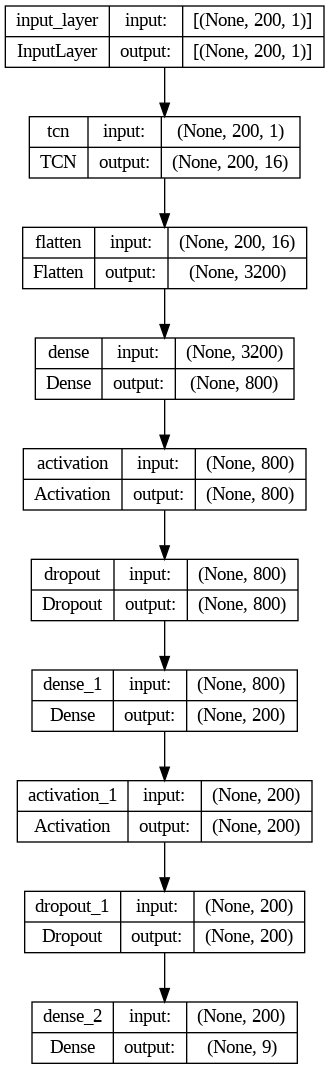

In [18]:
tfk.utils.plot_model(model, show_shapes=True)

In [19]:
lr_patience = 5
es_patience = 15
num_batches = int(np.ceil(X_train.shape[0] / batch_size))
callbacks = [
  tfk.callbacks.TerminateOnNaN(),
  tfk.callbacks.ReduceLROnPlateau('val_loss', patience=lr_patience, factor=0.3, min_lr=1e-5, verbose=1),
  tfk.callbacks.EarlyStopping('val_loss', patience=es_patience, min_delta=1e-4, restore_best_weights=True, verbose=1),
  tfk.callbacks.ModelCheckpoint('checkpoints/' + model_name + '_{epoch:02d}', monitor='val_loss', save_freq=(num_batches * 3))
]

## Train model

In [20]:
# Train the model and save its history
model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
)

Epoch 1/200
603/603 [==============================] - 26s 25ms/step - loss: 0.0346 - mae: 0.1279 - val_loss: 0.0105 - val_mae: 0.0710 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 15s 25ms/step - loss: 0.0150 - mae: 0.0890 - val_loss: 0.0105 - val_mae: 0.0688 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 21s 35ms/step - loss: 0.0132 - mae: 0.0820 - val_loss: 0.0098 - val_mae: 0.0656 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 12s 21ms/step - loss: 0.0122 - mae: 0.0779 - val_loss: 0.0097 - val_mae: 0.0665 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0117 - mae: 0.0756 - val_loss: 0.0099 - val_mae: 0.0678 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 21s 35ms/step - loss: 0.0112 - mae: 0.0733 - val_loss: 0.0093 - val_mae: 0.0636 - lr: 9.0000e-04
Epoch 7/200
603/603 [==============================] - 13s 21ms/step - loss: 0.0109 - mae: 0.0723 - val_loss

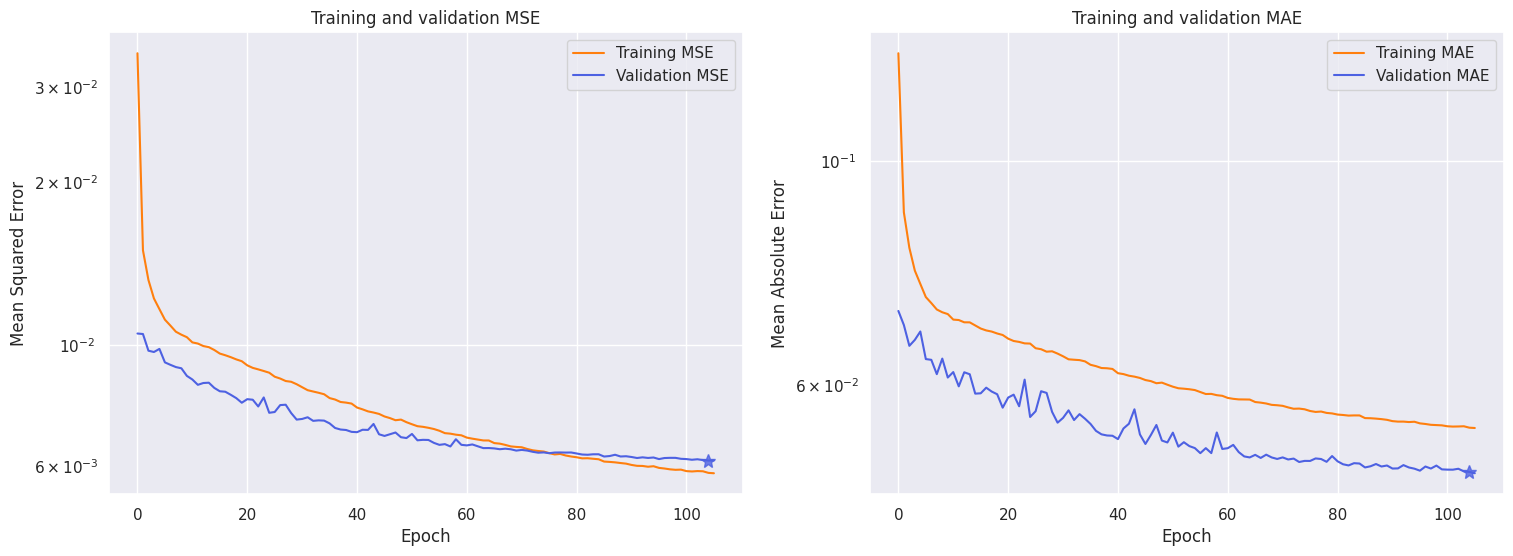

In [21]:
plot_history(model.history.history, log_scale=True)

In [22]:
# Save the trained model
model.save('models/' + model_name)
del model

In [23]:
model = tfk.models.load_model('checkpoints/' + model_name + '_78')

In [24]:
mse, mae = model.evaluate(X_train, y_train)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

4822/4822 [==============================] - 22s 4ms/step - loss: 0.0042 - mae: 0.0424
Mean Squared Error: 0.004153034649789333
Mean Absolute Error: 0.042432352900505066


In [25]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 2s 4ms/step - loss: 0.0063 - mae: 0.0507
Mean Squared Error: 0.006344767287373543
Mean Absolute Error: 0.05066679045557976
